In [2]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [3]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

In [8]:
layer_size = 10*4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
print('W', W.shape, W.max(), W.min(), np.median(W))

T = np.zeros(O.shape)

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

speed_T = 1
inc_T = 0.03 * speed_T
dec_T = 0.001 * speed_T
flr_T = 0 + prec

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]
        I = np.abs(np.array(img) - 255) / 255

        # infer
        O = np.dot(W, I)

        # threshold
        # TO = np.copy(O)
        O[np.where(O < T)] = 0
        # if np.max(TO) > np.min(O):
        #     O = TO
        print(f'{np.sum(O >= T)=}')
        print(f'{O[np.where(O >= T)]=}')
        if np.sum(O >= T) == 0:
            continue

        # train
        winner_ids = np.argsort(O)[::-1]

        D = np.zeros(O.shape)
        D[winner_ids[0]] = 1
        D[winner_ids[1:1+k]] += -push_delta
        D = D[np.newaxis].T

        dW = I - (W * O[np.newaxis].T)

        # norm
        nc = np.max(np.abs(dW), axis=1)
        # nc = np.linalg.norm(dW, axis=1, ord=1)
        nc[np.where(nc < prec)] = prec
        nc = nc[np.newaxis].T
        dW /= nc

        # print(f'{np.sum(dW < 0)=}')

        # update
        W += dW * D * eps

        # train T
        dT = np.zeros(T.shape)
        dT += -dec_T
        dT[winner_ids[0]] = inc_T
        dT[winner_ids[1:1+k]] = 0

        # update T
        T += dT * eps
        T[np.where(T < flr_T)] = flr_T

print('W', W.shape, W.max(), W.min(), np.median(W))
print('T', T.shape, T.max(), T.min(), np.median(T))

W (40, 784) 0.00099992900813167 9.543451797633384e-08 0.0004980346691921802
np.sum(O >= T)=40
O[np.where(O >= T)]=array([0.3260774 , 0.33413934, 0.33514966, 0.33926057, 0.33196177,
       0.32730281, 0.33708773, 0.34726279, 0.32950569, 0.32470852,
       0.33312775, 0.32182455, 0.32860054, 0.33241853, 0.34251552,
       0.3440841 , 0.32802429, 0.32738295, 0.33604469, 0.32579859,
       0.32716184, 0.3395475 , 0.32384859, 0.3289343 , 0.32949904,
       0.32989859, 0.32796781, 0.31795874, 0.34007599, 0.33913666,
       0.33190939, 0.33151251, 0.33433353, 0.34292098, 0.33726301,
       0.3300607 , 0.3327419 , 0.33630875, 0.33816903, 0.33587138])
np.sum(O >= T)=39
O[np.where(O >= T)]=array([3.53111496e-01, 3.65370606e-01, 3.64489810e-01, 3.71145156e-01,
       3.67575036e-01, 3.55744693e-01, 3.62236541e-01, 1.24395291e+03,
       3.58042845e-01, 3.53592837e-01, 3.61330897e-01, 3.49952135e-01,
       3.58271017e-01, 3.60824747e-01, 3.73891328e-01, 3.56673368e-01,
       3.55623976e-01, 3.63

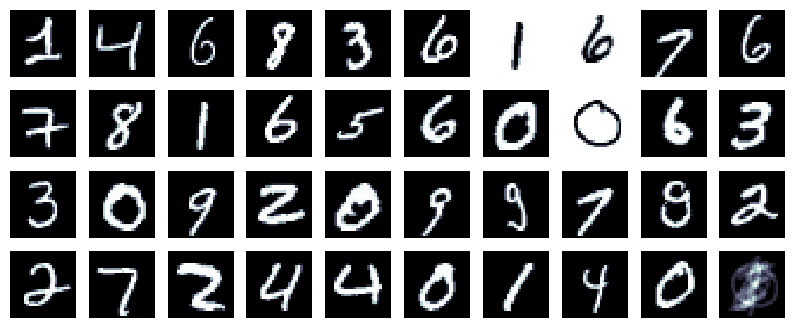

In [9]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg,
               interpolation='none',
               aspect='auto',
               cmap='bone',  # seismic
            #    vmax=1,
            #    vmin=-1,
               #    vmax=np.max(np.abs(aimg)),
               #    vmin=-np.max(np.abs(aimg))
               )
        axis("off")

show()